In [144]:
#Importing necessary packages
import os
import requests
import matplotlib
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn.apionly as sns
from statsmodels.api import OLS
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pandas.core import datetools
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [145]:
#Setting up workspace
url = 'https://github.com/ThomasShayHill/Miami/blob/master/Miami%20Sales%20with%20Elevation%20AG%20107K%20indexed%201971.xlsx?raw=true'
Miami_SF = pd.read_excel(url)

In [146]:
#Removing unnecessary predictors
predictors = list(Miami_SF.columns.values)

predictors.remove('X')
predictors.remove('Zip_5char')
predictors.remove('date_sale_1_num')
predictors.remove('date_sale_2_num')
predictors.remove('price_relative')
predictors.remove('Address') 
predictors.remove('Zip')
predictors.remove('Assessed')
predictors.remove('Bath')
predictors.remove('Stories')
predictors.remove('Units')
predictors.remove('Sale_Date_1')
predictors.remove('Sale_Date_2')
predictors.remove('Sale_Amount_2')
predictors.remove('Total_Appreciation')
predictors.remove('By_Year')
predictors.remove('City')
predictors.remove('Old_Land_Use_Categories')
predictors.remove('price_relative_ind')
predictors.remove('Bed')
predictors.remove('New_Land_Use')
predictors.remove('Sale_Amount_1')

In [147]:
#Setting up for Linear regression
msk = np.random.rand(len(Miami_SF)) < 0.5
data_train = Miami_SF[msk]
data_test = Miami_SF[~msk]

y_train = data_train['price_relative_ind'].values
x_train = data_train[predictors]
y_test = data_test['price_relative_ind'].values
x_test = data_test[predictors]

In [148]:
#Regression results using Statsmodels
mod = sm.OLS(y_train, x_train)
linear = mod.fit()
linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     5272.
Date:                Fri, 22 Dec 2017   Prob (F-statistic):               0.00
Time:                        11:06:19   Log-Likelihood:                -92799.
No. Observations:               53904   AIC:                         1.856e+05
Df Residuals:                   53901   BIC:                         1.856e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
YearBuilt      0.0003   1.15e-05     23.032      0.000       0.000       0.000
LivingSqFt  4.195e-05   6.81e-06      6.162      0.000    2.86e-05    5.53e-05
Elevation      0.0610      0.008      7.189      0.000       0.044       0.078
==============================================================================
Omnibus:                    89209.698   Durbin-Watson:                   1.603
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        145440300.629
Skew:                          10.878   Prob(JB):                         0.00
Kurtosis:                     256.539   Cond. No.                     4.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [149]:
#Linear Mixed Effects
md = smf.mixedlm('price_relative_ind~YearBuilt+LivingSqFt',data=Miami_SF,groups='City',re_formula = '~0+Elevation') #Trying to suppress intercept by putting 0 + Elevation
mdf = md.fit()
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: price_relative_ind
No. Observations: 107984  Method:             REML              
No. Groups:       33      Scale:              1.7552            
Min. group size:  5       Likelihood:         -183666.4262      
Max. group size:  58804   Converged:          Yes               
Mean group size:  3272.2                                        
-----------------------------------------------------------------
                 Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept        26.061     0.481   54.151  0.000  25.118  27.004
YearBuilt        -0.013     0.000  -52.908  0.000  -0.013  -0.012
LivingSqFt        0.000     0.000   21.945  0.000   0.000   0.000
Elevation RE      0.013     0.004                                



In [150]:
mdf.random_effects

{'Aventura': Elevation   -0.084027
 dtype: float64, 'Bal Harbour': Elevation    0.018619
 dtype: float64, 'Bay Harbor Islands': Elevation   -0.060519
 dtype: float64, 'Biscayne Park': Elevation   -0.101682
 dtype: float64, 'Coral Gables': Elevation   -0.076789
 dtype: float64, 'Cutler Bay': Elevation   -0.040797
 dtype: float64, 'Doral': Elevation   -0.089607
 dtype: float64, 'El Portal': Elevation   -0.168777
 dtype: float64, 'Golden Beach': Elevation   -0.009354
 dtype: float64, 'Hialeah': Elevation    0.064042
 dtype: float64, 'Hialeah Gardens': Elevation   -0.022014
 dtype: float64, 'Indian Creek': Elevation    0.239746
 dtype: float64, 'Key Biscayne': Elevation    0.205505
 dtype: float64, 'Medley': Elevation    0.155302
 dtype: float64, 'Miami': Elevation   -0.023704
 dtype: float64, 'Miami Beach': Elevation   -0.254171
 dtype: float64, 'Miami Gardens': Elevation    0.066481
 dtype: float64, 'Miami Lakes': Elevation   -0.065356
 dtype: float64, 'Miami Shores': Elevation   -0.1571

Note: The "Elevation" coefficient reported above is the random effect of Elevation in each city - i.e. the deviation of that city's elevation coefficient from the mean of 0.013. 

Next: How can we find the standard deviation of each random-effect group - i.e. so that we can determine which cities have a relationship between elevation and appreciation that is statistically different from 0 at the 95% confidence level? Do we simply add the overall Elevation Random Effect standard error?

In [151]:
#Zipping all of this up into a dataframe
Cities = list(set(Miami_SF['City']))
Cities_set = []
for c in Cities:
    City_properties = Miami_SF[Miami_SF['City']==c]
    if len(City_properties)>200:
        Cities_set.append(c)

#effects_intercept = [] ###Note that putting the 0 in the formula suppressed the generation of a random intercept
effects_slope = []
for i in Cities_set:
    #effects_intercept.append(mdf.random_effects[i][0])
    effects_slope.append(mdf.random_effects[i][0])

Cities_Random_Effects = pd.DataFrame(
        {'Cities': Cities_set,
         #'Random Intercept': effects_intercept,
         'Random Slope': effects_slope})

Cities_Random_Effects = Cities_Random_Effects.sort_values(['Random Slope'])
Cities_Random_Effects

#Cities Random Effects Dictionary
Cities_RE_dict = dict(zip(Cities_set,effects_slope))

In [152]:
#Getting confidence intervals for each of these parameters
conf_ints = mdf.conf_int(alpha=0.05)
conf_ints = conf_ints.rename(columns={0:'Lower Bound',1:'Upper Bound'})

conf_ints

,Lower Bound,Upper Bound
Intercept,25.117910,27.004442
YearBuilt,-0.013429,-0.012470
LivingSqFt,0.000105,0.000126
Elevation RE,0.001426,0.013314


In [153]:
mdf.bse_re[0]

0.0040177956923179246

In [154]:
#GETTING CONFIDENCE INTERVALS BY CITY
lower_bounds = []
upper_bounds = []
scores = []
for i in Cities_set:
    lower_bound = mdf.random_effects[i][0]-2*mdf.bse_re[0] #Find the lower bound by subtracting 2*the Elevation standard error
    lower_bounds.append(lower_bound)
    
    upper_bound = mdf.random_effects[i][0]+2*mdf.bse_re[0] #Find upper bound by adding 2*standard error
    upper_bounds.append(upper_bound)
    
    scores.append(mdf.random_effects[i][0])
    
Cities_df = pd.DataFrame({
        'Cities': Cities_set,
        'Lower Bound': lower_bounds,
        'Predicted Score': scores,
        'Upper_Bound': upper_bounds})

Cities_sig = Cities_df[Cities_df['Lower Bound']>0]

In [155]:
Cities_sig

,Cities,Lower Bound,Predicted Score,Upper_Bound
0,Unincorporated County,0.000705,0.008740,0.016776
1,Hialeah,0.056006,0.064042,0.072077
3,Miami Gardens,0.058446,0.066481,0.074517
6,Surfside,0.039472,0.047507,0.055543
11,Opa-Locka,0.078332,0.086368,0.094403
14,Sweetwater,0.047418,0.055453,0.063489
18,West Miami,0.007962,0.015998,0.024034
21,Key Biscayne,0.197469,0.205505,0.213540
23,South Miami,0.018995,0.027031,0.035066


In [156]:
sig_list = list(Cities_sig['Cities'])

In [157]:
#Getting predicted and actual values for each city
Yhats_list = []
for i in sig_list:
    dataset = Miami_SF[Miami_SF['City']==i]
    city_elevs = dataset['Elevation']
    yhats = mdf.predict(dataset)
    actual = dataset['price_relative_ind']
    city_coefs = pd.DataFrame({
            'Elevations': city_elevs,
            'Fitted Values': yhats,
            'Actual Values': actual})
    Yhats_list.append(city_coefs)
Yhats_dict = dict(zip(sig_list,Yhats_list))

In [158]:
Cities_RE_dict

{'Aventura': -0.084026763012346822,
 'Biscayne Park': -0.10168215012201505,
 'Coral Gables': -0.076788706661457304,
 'Cutler Bay': -0.040797010503993467,
 'Doral': -0.089607277792066731,
 'El Portal': -0.16877700640174034,
 'Hialeah': 0.064041652926087725,
 'Hialeah Gardens': -0.022014370964121222,
 'Key Biscayne': 0.2055047778611637,
 'Miami': -0.023704385267724316,
 'Miami Beach': -0.25417148342655099,
 'Miami Gardens': 0.066481360481434285,
 'Miami Lakes': -0.065356400763288344,
 'Miami Shores': -0.15719524903914048,
 'Miami Springs': -0.114447495195941,
 'North Miami': -0.062071045056932672,
 'North Miami Beach': -0.050138412009762275,
 'Opa-Locka': 0.086367569577980502,
 'Palmetto Bay': -0.011945412439970576,
 'Pinecrest': -0.0042100795419943281,
 'South Miami': 0.027030584842431492,
 'Surfside': 0.047507390916240212,
 'Sweetwater': 0.055453328775985786,
 'Unincorporated County': 0.0087402116885677214,
 'West Miami': 0.015997969667104223}

In [159]:
def plot_actual_values(city,ymin,ymax):
    x = Yhats_dict[city]['Elevations']
    y = Yhats_dict[city]['Actual Values']

    # Find the slope and intercept of the best fit line
    #intercept, slope = Cities_RE_dict[city][0],Cities_RE_dict[city][1] 
    
    # Create a list of values in the best fit line
    #abline_values = [slope * i + intercept for i in x] #IS THERE A WAY TO DO THIS? TO PLOT THE PREDICTION LINE?


    plt.scatter(x, y)
    #plt.yscale('log') It may or may not make sense to have the yaxis on a log scale
    plt.ylim(ymin,ymax)
    #plt.plot(x, abline_values, 'r')
    plt.title(str(city))
    plt.xlabel('Elevation')
    plt.ylabel('Price Appreciation')
    #plt.savefig(str(city)+' Elevation and Appreciation')
    

#for i in sig_list:
#    plot_actual_values(i)

In [160]:
def plot_fitted_values(city,ymin,ymax):
    x = Yhats_dict[city]['Elevations']
    y = Yhats_dict[city]['Fitted Values']

    # Find the slope and intercept of the best fit line
    #intercept, slope = Cities_RE_dict[city][0],Cities_RE_dict[city][1] 
    
    # Create a list of values in the best fit line
    #abline_values = [slope * i + intercept for i in x] #IS THERE A WAY TO DO THIS? TO PLOT THE PREDICTION LINE?


    plt.scatter(x, y)
    plt.ylim(ymin,ymax)
    #plt.yscale('log')
    #plt.plot(x, abline_values, 'r')
    plt.title(str(city))
    plt.xlabel('Elevation')
    plt.ylabel('Price Appreciation')
    #plt.savefig(str(city)+' Elevation and Appreciation')
    

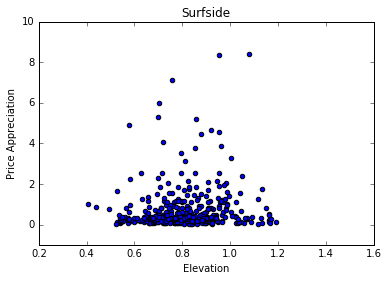

In [161]:
plot_actual_values('Surfside',-1,10)

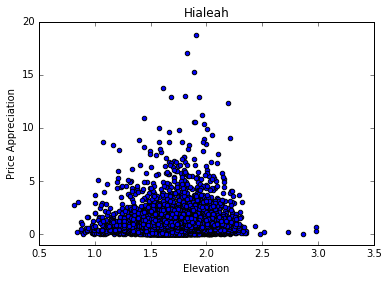

In [162]:
plot_actual_values('Hialeah',-1,20)

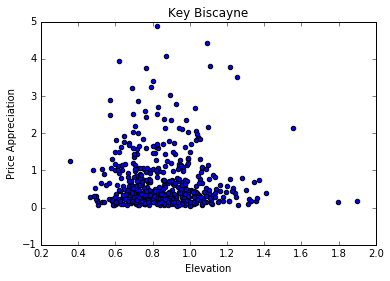

In [163]:
plot_actual_values('Key Biscayne',-1,5)

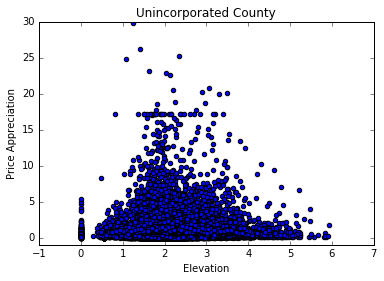

In [164]:
plot_actual_values('Unincorporated County',-1,30)

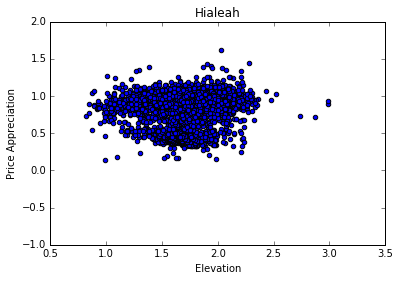

In [165]:
plot_fitted_values('Hialeah',-1,2)

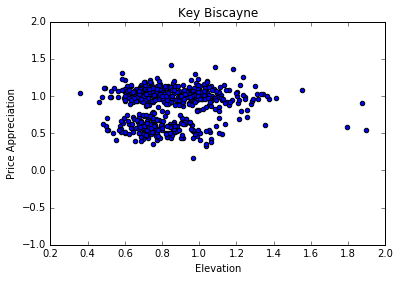

In [166]:
plot_fitted_values('Key Biscayne',-1,2)